In [1]:
import math
import matplotlib.pyplot as plt

In [2]:
def get_all_values_by_SCA(pores, matrix, sampling_step = 100):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p, asp_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
        # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m, asp_m]
    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1, asp1 = pores
    k2, n2, asp2 = matrix

    kbr = []
    nbr = []
    por = []

    # чтобы нигде не было деления на 0
    if asp1 == 1:
        asp1 = 0.99
    if asp2 == 1:
        asp2 = 0.99



    # вычислим theta и fn (через аспектное отношения), которые понадобятся для дальнейших рассчетов

    # asp < 1 - oblate spheroid (сплюснутый элипсоид)
    if asp1 < 1:
        theta1 = (asp1 / ((1 - asp1 ** 2) ** (3 / 2))) * (math.acos(asp1) - asp1 * math.sqrt(1 - asp1 ** 2))
        fn1 = (asp1 ** 2 / (1 - asp1 ** 2)) * (3 * theta1 - 2)

    if asp2 < 1:
        theta2 = (asp2 / ((1 - asp2 ** 2) ** (3 / 2))) * (math.acos(asp2) - asp2 * math.sqrt(1 - asp2 ** 2))
        fn2 = (asp2 ** 2 / (1 - asp2 ** 2)) * (3 * theta2 - 2)

    # asp > 1 - prolate spheroid (вытянутый элипсоид)
    if asp1 > 1:
        theta1 = (asp1 / ((asp1 ** 2 - 1) ** (3 / 2))) * (asp1 * math.sqrt(asp1 ** 2 - 1) - math.acosh(asp1))
        fn1 = (asp1 ** 2 / (asp1 ** 2 - 1)) * (2 - 3 * theta1)

    if asp2 > 1:
        theta2 = (asp2 / ((asp2 ** 2 - 1) ** (3 / 2))) * (asp2 * math.sqrt(asp2 ** 2 - 1) - math.acosh(asp2))
        fn2 = (asp2 ** 2 / (asp2 ** 2 - 1)) * (2 - 3 * theta2)


    epsilon = 1e-7   # опять же, чтобы нигде не было деления на ноль

    if k1 == 0:
        k1 = epsilon
    if k2 == 0:
        k2 = epsilon
    if n1 == 0:
        n1 = epsilon
    if n2 == 0:
        n2 = epsilon

    # пройдем по всем значениям пористости от 0 до 100%
    # x1 - пористость, x2 - содержание твердой компоненты
    for x1 in [epsilon] + [i /sampling_step for i in range(1, sampling_step)] + [1 - epsilon]:
        x2 = 1 - x1

        ksc = x1 * k1 + x2 * k2
        nsc = x1 * n1 + x2 * n2
        knew = 0
        nnew = 0
        tol = 1e-6 * k1
        d = abs(ksc - knew)
        niter = 0

        if nsc == 0:
            pass

        while (d > abs(tol)) and (niter < 3000):
            nusc = (3 * ksc - 2 * nsc) / (2 * (3 * ksc + nsc))
            a1 = n1 / nsc - 1
            a2 = n2 / nsc - 1
            b1 = (1 / 3) * (k1 / ksc - n1 / nsc)
            b2 = (1 / 3) * (k2 / ksc - n2 / nsc)
            r = (1 - 2 * nusc) / (2 * (1 - nusc))

            f11 = 1 + a1 * ((3 / 2) * (fn1 + theta1) - r * ((3 / 2) * fn1 + (5 / 2) * theta1 - (4 / 3)))
            f12 = 1 + a2 * ((3 / 2) * (fn2 + theta2) - r * ((3 / 2) * fn2 + (5 / 2) * theta2 - (4 / 3)))

            f21 = 1 + a1 * (1 + (3 / 2) * (fn1 + theta1) - (r / 2) * (3 * fn1 + 5 * theta1)) + b1 * (3 - 4 * r)
            f21 = f21 + (a1 / 2) * (a1 + 3 * b1) * (3 - 4 * r) * (fn1 + theta1 - r * (fn1 - theta1 + 2 * theta1 ** 2))
            f22 = 1 + a2 * (1 + (3 / 2) * (fn2 + theta2) - (r / 2) * (3 * fn2 + 5 * theta2)) + b2 * (3 - 4 * r)
            f22 = f22 + (a2 / 2) * (a2 + 3 * b2) * (3 - 4 * r) * (fn2 + theta2 - r * (fn2 - theta2 + 2 * theta2 ** 2))

            f31 = 1 + a1 * (1 - (fn1 + (3 / 2) * theta1) + r * (fn1 + theta1))
            f32 = 1 + a2 * (1 - (fn2 + (3 / 2) * theta2) + r * (fn2 + theta2))

            f41 = 1 + (a1 / 4) * (fn1 + 3 * theta1 - r * (fn1 - theta1))
            f42 = 1 + (a2 / 4) * (fn2 + 3 * theta2 - r * (fn2 - theta2))

            f51 = a1 * (-fn1 + r * (fn1 + theta1 - (4 / 3))) + b1 * theta1 * (3 - 4 * r)
            f52 = a2 * (-fn2 + r * (fn2 + theta2 - (4 / 3))) + b2 * theta2 * (3 - 4 * r)

            f61 = 1 + a1 * (1 + fn1 - r * (fn1 + theta1)) + b1 * (1 - theta1) * (3 - 4 * r)
            f62 = 1 + a2 * (1 + fn2 - r * (fn2 + theta2)) + b2 * (1 - theta2) * (3 - 4 * r)

            f71 = 2 + (a1 / 4) * (3 * fn1 + 9 * theta1 - r * (3 * fn1 + 5 * theta1)) + b1 * theta1 * (3 - 4 * r)
            f72 = 2 + (a2 / 4) * (3 * fn2 + 9 * theta2 - r * (3 * fn2 + 5 * theta2)) + b2 * theta2 * (3 - 4 * r)

            f81 = a1 * (1 - 2 * r + (fn1 / 2) * (r - 1) + (theta1 / 2) * (5 * r - 3)) + b1 * (1 - theta1) * (3 - 4 * r)
            f82 = a2 * (1 - 2 * r + (fn2 / 2) * (r - 1) + (theta2 / 2) * (5 * r - 3)) + b2 * (1 - theta2) * (3 - 4 * r)

            f91 = a1 * ((r - 1) * fn1 - r * theta1) + b1 * theta1 * (3 - 4 * r)
            f92 = a2 * ((r - 1) * fn2 - r * theta2) + b2 * theta2 * (3 - 4 * r)

            p1 = 3 * f11 / f21
            p2 = 3 * f12 / f22
            q1 = (2 / f31) + (1 / f41) + ((f41 * f51 + f61 * f71 - f81 * f91) / (f21 * f41))
            q2 = (2 / f32) + (1 / f42) + ((f42 * f52 + f62 * f72 - f82 * f92) / (f22 * f42))

            p1 = p1 / 3
            p2 = p2 / 3
            q1 = q1 / 5
            q2 = q2 / 5

            knew = (x1 * k1 * p1 + x2 * k2 * p2) / (x1 * p1 + x2 * p2)
            nnew = (x1 * n1 * q1 + x2 * n2 * q2) / (x1 * q1 + x2 * q2)

            d = abs(ksc - knew)
            ksc = knew
            nsc = nnew
            niter = niter + 1

        por.append(x1)   # массив со значениями пористости
        kbr.append(ksc)
        nbr.append(nsc)

    return por, kbr, nbr

In [3]:
def get_moduli_by_SCA(get_all_values_by_SCA, pores, matrix, porosity):
    por, kbr, nbr = get_all_values_by_SCA(pores, matrix)

    index = por.index(porosity / 100)

    return [kbr[index], nbr[index]]

# Решение

### смешаем смесь (кальцит+доломит+ангидрит) и иллит с помощью SCA 

In [10]:
matrix = [63.11, 33.05, 1]
illite = [25.3, 16.3, 0.001]

# кальцит, доломит и ангидрит вместе составляют 85% объема композита (это как раз matrix)
# теперь добавим к этой смеси еще 10% иллита

matrix_proportion = 85
ill_proportion = 10

In [11]:
por, bulk, shear = get_all_values_by_SCA(illite, matrix, sampling_step = 100)

In [13]:
sum = matrix_proportion + ill_proportion
proportion = round((ill_proportion/sum)*100)

print('содержание иллита в смеси твердых компонент:', proportion)

содержание иллита в смеси твердых компонент: 11


In [33]:
def draw_HS_plots(por, bulk, shear, xlabel = 'proportion of illite (unit fractions)',
                 file_name = 'cal_dol_anh_ill(SCA).png'):
    plt.figure(figsize = (5,5))
    plt.plot(por, bulk, c = 'k')
    plt.plot(por, shear, c = 'r')
    plt.scatter(por[proportion], bulk[proportion], c = 'k')
    plt.scatter(por[proportion], shear[proportion], c = 'r')
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel('elastic moduli (GPa)', fontsize = 12)
    plt.legend(['bulk modulus', 'shear modulus'], fontsize = 11)
    
    #fig.savefig(file_name)

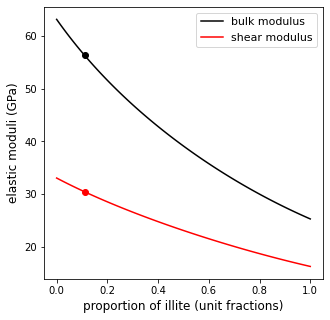

In [34]:
draw_HS_plots(por, bulk, shear, xlabel = 'proportion of illite (unit fractions)',
                 file_name = 'cal_dol_anh_ill(SCA).png')

In [35]:
print(por[proportion])
print(bulk[proportion])
print(shear[proportion])

0.11
56.30809043162402
30.4517568242186
